In [1]:

"""
---------------------------------
Clase C817 - UNI FIC
Prof. Alan Ayala, PhD. 
---------------------------------

Solución de la ecuación de Navier Stokes equations en una cavidad con una tapa
movediza usando el método de elementos finitos y proyecciones de Chorin.
Ver pag. 64 del manual de FreeFem++

Ecuación de Momentos: 
          ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f

Condición de incomprensibilidad:  ∇ ⋅ u = 0

Variables y Parámetros:

u:  Velocity (2d vector)
p:  Pressure
f:  Forcing (here =0)
ν:  Kinematic Viscosity
ρ:  Density (here =1)
t:  Time
∇:  Nabla operator (defining nonlinear convection, gradient and divergence)
∇²: Laplace Operator

----

Escenario gráfico:
                            ------>>>>> u_top

          1 +-------------------------------------------------+
            |                                                 |
            |             *                      *            |
            |          *           *    *    *                |
        0.8 |                                                 |
            |                                 *               |
            |     *       *                                   |
            |                      *     *                    |
        0.6 |                                            *    |
u = 0       |      *                             *            |   u = 0
v = 0       |                             *                   |   v = 0
            |                     *                           |
            |           *                *         *          |
        0.4 |                                                 |
            |                                                 |
            |      *            *             *               |
            |           *                             *       |
        0.2 |                       *           *             |
            |                               *                 |
            |  *          *      *                 *       *  |
            |                            *                    |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

                                    u = 0
                                    v = 0


Condiciones de borde:
* Todas las componentes de velocidad son 0 en el tiempo 0 en todos los bordes,
* excepto en la tapa.
"""

'\nSolución de la ecuación de Navier Stokes equations en una cavidad con una tapa\nmovediza usando el método de elementos finitos y proyecciones de Chorin.\nVer pag. 64 del manual de FreeFem++\n\nEcuación de Momentos: \n          ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f\n\nCondición de incomprensibilidad:  ∇ ⋅ u = 0\n\nVariables y Parámetros:\n\nu:  Velocity (2d vector)\np:  Pressure\nf:  Forcing (here =0)\nν:  Kinematic Viscosity\nρ:  Density (here =1)\nt:  Time\n∇:  Nabla operator (defining nonlinear convection, gradient and divergence)\n∇²: Laplace Operator\n\n----\n\nEscenario gráfico:\n                            ------>>>>> u_top\n\n          1 +-------------------------------------------------+\n            |                                                 |\n            |             *                      *            |\n            |          *           *    *    *                |\n        0.8 |                                                 |\n            |               

In [1]:
from fenics import *
from mshr import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
# Parámetros:
N_POINTS_P_AXIS = 41
TIME_STEP_LENGTH = 0.01
N_TIME_STEPS = 100
KINEMATIC_VISCOSITY = 0.01 # -> Re = 100

In [14]:
mesh = UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS)

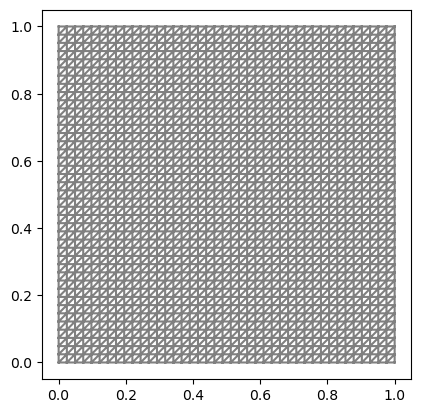

In [15]:
plot(mesh)

In [16]:
# Elementos tipo Taylor-Hood.
# Espacio de funciones para la presión debe ser de un orden menor que de velocidad.
velocity_function_space = VectorFunctionSpace(mesh, "Lagrange", 2) # u0(x) = a00*p1(x) + ... + an0*pn(x)
pressure_function_space = FunctionSpace(mesh, "Lagrange", 1)  # p0(x) = b00*q1(x) + ... + bn0*qn(x)

u_trial = TrialFunction(velocity_function_space)
p_trial = TrialFunction(pressure_function_space)
v_test = TestFunction(velocity_function_space)
q_test = TestFunction(pressure_function_space)

In [17]:
# Condición de borde
stationary_wall_boundary_condition = DirichletBC(
    velocity_function_space,
    (0.0, 0.0),
    """
    on_boundary && (x[0] < DOLFIN_EPS || x[1] < DOLFIN_EPS || x[0] > (1.0 - DOLFIN_EPS))
    """
)
moving_wall_boundary_condition = DirichletBC(
    velocity_function_space,
    (1.0, 0.0),
    """
    on_boundary && (x[1] > (1.0 - DOLFIN_EPS))
    """
)
velocity_boundary_conditions = [stationary_wall_boundary_condition, moving_wall_boundary_condition]


In [18]:
# Vectores de velocidad y presión
u_prev = Function(velocity_function_space)
u_tent = Function(velocity_function_space)
u_next = Function(velocity_function_space)
p_next = Function(pressure_function_space)

In [20]:
# Forma débil de la ecuación de momento
momentum_weak_form_residuum = (
    1.0 / TIME_STEP_LENGTH * inner(u_trial - u_prev, v_test) * dx
    +
    inner(grad(u_prev) * u_prev, v_test) * dx
    +
    KINEMATIC_VISCOSITY * inner(grad(u_trial), grad(v_test)) * dx
)
momentum_weak_form_lhs = lhs(momentum_weak_form_residuum)
momentum_weak_form_rhs = rhs(momentum_weak_form_residuum)

# Forma débil de la ecuación de presión
pressure_poisson_weak_form_lhs = inner(grad(p_trial), grad(q_test)) * dx
pressure_poisson_weak_form_rhs = - 1.0 / TIME_STEP_LENGTH * div(u_tent) * q_test * dx

# Forma débil de la ecuación de velocidad
velocity_update_weak_form_lhs = inner(u_trial, v_test) * dx
velocity_update_weak_form_rhs = (
    inner(u_tent, v_test) * dx
    -
    TIME_STEP_LENGTH * inner(grad(p_next), v_test) * dx
)


In [21]:
# Pre-ensamblaje de sistema de matrices, K u = f, u = K^{-1} f
momentum_assembled_system_matrix = assemble(momentum_weak_form_lhs)
pressure_poisson_assembled_system_matrix = assemble(pressure_poisson_weak_form_lhs)
velocity_update_assembled_system_matrix = assemble(velocity_update_weak_form_lhs)


In [ ]:
# Visualización:

for t in tqdm(range(N_TIME_STEPS)):
    # (1) Obteniendo la velocidad tentativa
    momentum_assembled_rhs = assemble(momentum_weak_form_rhs)
    [bc.apply(momentum_assembled_system_matrix, momentum_assembled_rhs) for bc in velocity_boundary_conditions]
    solve(
        momentum_assembled_system_matrix,
        u_tent.vector(),
        momentum_assembled_rhs,
        "gmres",
        "ilu",
    )

    # (2) Obteniendo la presión
    pressure_poisson_assembled_rhs = assemble(pressure_poisson_weak_form_rhs)
    solve(
        pressure_poisson_assembled_system_matrix,
        p_next.vector(),
        pressure_poisson_assembled_rhs,
        "gmres",
        "amg",
    )

    # (3) Obteniendo la velocidad final corregiendo con la condición de incompresibilidad
    [bc.apply(momentum_assembled_system_matrix, momentum_assembled_rhs) for bc in velocity_boundary_conditions]
    velocity_update_assembled_rhs = assemble(velocity_update_weak_form_rhs)
    solve(
        velocity_update_assembled_system_matrix,
        u_next.vector(),
        velocity_update_assembled_rhs,
        "gmres",
        "ilu",
    )

    # Siguiente iteración de tiempo
    u_prev.assign(u_next)

    # Visualización
    plot(u_next)
    plt.draw()
    plt.pause(0.02)
    plt.clf()